## Inspiration Paper
The paper, written by Begio et al. in 2013, resembles our previous model in PT2, but process more than just a character at a time. Instead, it processes a word at a time as a 30 dimensional vector. [Source here](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [80]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

In [2]:
!curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   586k      0 --:--:-- --:--:-- --:--:--  586k


In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [88]:
block_size = 3
X, Y = [], []

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Before we move on, let's quickly describe what the data represents at each dimension:
* `X[0]` are the examples. Each one is a group of three letters.
* `X[1]` are the actual characters. For the first example, the first three letters are all '.', so the whole group looks like '...'

How about the Y dimensions?
* `Y` only has 1 dimension - a single list, which at each index represents the next character, based on the corresponding group in `X`. So, from the group `X[0]` (which is '...'), the next character is `Y[0]` (which is 'e').  

## Embedding Letters into a 2-Dimensional Space

In [8]:
C = torch.randn((27, 2))

In [14]:
C[5]

tensor([-1.2837, -0.3350])

In [13]:
# Our one-hot encoded F acts as a lookup take through matrix multiplication (Gilbert Strang's combination of rows)
f = F.one_hot(torch.tensor(5), num_classes = 27).float() # first input must be a torch.Tensor
f @ C

tensor([-1.2837, -0.3350])

We'll do indexing instead of matrix multiplication, since it's faster. But they return the same result.

It's even possible to index using a tensor. For example, in the following code, we do `C[X]`, which returns a matrix of dimensions (32, 3, 2). What does this do? For every item in the dimension (32), then for ever item in the second dimension (3), it returns the index of that item on C.

As an example: `X[0]` is an array of `[0, 0, 0]`. For each of these items, we index C, such that we'll have a new dimension: `[C[0], C[0], C[0]]`.

In [33]:
C[torch.tensor([5,6,7])]

tensor([[-1.2837e+00, -3.3501e-01],
        [ 9.3003e-01,  5.4799e-04],
        [ 8.8054e-01,  6.2262e-01]])

In [27]:
X.shape, C[X].shape

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

In [32]:
C[X], X

(tensor([[[ 0.3796, -0.6887],
          [ 0.3796, -0.6887],
          [ 0.3796, -0.6887]],
 
         [[ 0.3796, -0.6887],
          [ 0.3796, -0.6887],
          [-1.2837, -0.3350]],
 
         [[ 0.3796, -0.6887],
          [-1.2837, -0.3350],
          [-0.3893,  1.2086]],
 
         [[-1.2837, -0.3350],
          [-0.3893,  1.2086],
          [-0.3893,  1.2086]],
 
         [[-0.3893,  1.2086],
          [-0.3893,  1.2086],
          [-1.9049, -0.1968]],
 
         [[ 0.3796, -0.6887],
          [ 0.3796, -0.6887],
          [ 0.3796, -0.6887]],
 
         [[ 0.3796, -0.6887],
          [ 0.3796, -0.6887],
          [ 0.8681, -1.9912]],
 
         [[ 0.3796, -0.6887],
          [ 0.8681, -1.9912],
          [-0.1261,  1.0783]],
 
         [[ 0.8681, -1.9912],
          [-0.1261,  1.0783],
          [-0.3737, -1.0959]],
 
         [[-0.1261,  1.0783],
          [-0.3737, -1.0959],
          [-0.4543,  0.5207]],
 
         [[-0.3737, -1.0959],
          [-0.4543,  0.5207],
          

In [35]:
X[13, 2], C[1], C[X[13,2]]

(tensor(1), tensor([-1.9049, -0.1968]), tensor([-1.9049, -0.1968]))

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

So what is `emb`? It's the values of `C` that apply to the specific letters in each group of `X` (which are all the examples).

In an example, `C` has two values that represent the next character (thus the dimensions are 27,2). `X` has dimensions (32, 3), so 32 examples and three characters per example. Instead of storing just the character, instead now we store the two values from `C` that represent the character.

In [37]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

What we want to do is now: `emb @ W1 + b`. This is a matrix multiplication with some weights plus a bias - simple enough. However, the dimensions of `emb` and `W1` don't alllow us to multiply.

So we're going to concatenate the dimensions of emb within an example. Meaning, for each example (32 total), we want a list of size 6 which has the representations (still from `C`) of each of the characters (which there are 3 of).

In [47]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [50]:
torch.cat(torch.unbind(emb, 1), 1).shape # An equivalent operation as above

torch.Size([32, 6])

`torch.unbind()` removes a single dimension of a tensor and returns a tuple of all the slices. In our example, this means removing the dimension that holds all the character representations. Now we have a tuple (can be thought of as a list) of all the character representations in all of our examples. Seen below:

In [52]:
torch.unbind(emb, 1)

(tensor([[ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [-1.2837, -0.3350],
         [-0.3893,  1.2086],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.8681, -1.9912],
         [-0.1261,  1.0783],
         [-0.3737, -1.0959],
         [-0.4543,  0.5207],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [-1.9049, -0.1968],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [-0.3737, -1.0959],
         [-1.3397,  0.4640],
         [-1.9049, -0.1968],
         [-2.0900, -0.8906],
         [-1.2837, -0.3350],
         [-0.1261,  1.0783],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [-1.3397,  0.4640],
         [ 0.8681, -1.9912],
         [ 1.2227, -0.7699],
         [ 1.0645, -0.6690]]),
 tensor([[ 0.3796, -0.6887],
         [ 0.3796, -0.6887],
         [-1

In [53]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [54]:
a.shape

torch.Size([18])

In [58]:
a.view(2, 9) # Very efficient, since numbers in memory are changed, but the representation of the tensor in python changes

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [59]:
emb.shape

torch.Size([32, 3, 2])

Hmm...how about we just make PyTorch view this Tensor in different dimensions?

In [60]:
emb.view(32, 6)

tensor([[ 0.3796, -0.6887,  0.3796, -0.6887,  0.3796, -0.6887],
        [ 0.3796, -0.6887,  0.3796, -0.6887, -1.2837, -0.3350],
        [ 0.3796, -0.6887, -1.2837, -0.3350, -0.3893,  1.2086],
        [-1.2837, -0.3350, -0.3893,  1.2086, -0.3893,  1.2086],
        [-0.3893,  1.2086, -0.3893,  1.2086, -1.9049, -0.1968],
        [ 0.3796, -0.6887,  0.3796, -0.6887,  0.3796, -0.6887],
        [ 0.3796, -0.6887,  0.3796, -0.6887,  0.8681, -1.9912],
        [ 0.3796, -0.6887,  0.8681, -1.9912, -0.1261,  1.0783],
        [ 0.8681, -1.9912, -0.1261,  1.0783, -0.3737, -1.0959],
        [-0.1261,  1.0783, -0.3737, -1.0959, -0.4543,  0.5207],
        [-0.3737, -1.0959, -0.4543,  0.5207, -0.3737, -1.0959],
        [-0.4543,  0.5207, -0.3737, -1.0959, -1.9049, -0.1968],
        [ 0.3796, -0.6887,  0.3796, -0.6887,  0.3796, -0.6887],
        [ 0.3796, -0.6887,  0.3796, -0.6887, -1.9049, -0.1968],
        [ 0.3796, -0.6887, -1.9049, -0.1968, -0.4543,  0.5207],
        [-1.9049, -0.1968, -0.4543,  0.5

In [61]:
emb.view(32, 6) == torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [64]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h

tensor([[-0.3013, -0.7755,  0.9924,  ..., -0.7615, -0.2849, -0.9413],
        [ 0.9532,  0.9841,  0.8340,  ...,  0.8983,  0.9084, -0.9967],
        [ 0.7272,  0.9961,  0.9891,  ...,  0.8124, -0.9510,  0.4458],
        ...,
        [-0.9403, -0.9986,  1.0000,  ..., -0.9998, -0.9287, -0.8923],
        [ 0.6774,  0.4011,  0.9925,  ...,  0.2726,  0.9403, -0.9988],
        [ 0.9959,  0.9998,  0.9651,  ...,  0.9947,  0.8992, -0.9936]])

In [65]:
h.shape

torch.Size([32, 100])

Be careful with broadcasting:

In our `emb.view(emb.shape[0], 6) @ W1 + b1`, our bias matrix, `b1` was broadcasted into a (1, 100) matrix. Meaning, the same bias will duplicated and then added to all the rows of `emb.view(emb.shape[0], 6) @ W1`.

In [66]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [67]:
logits = h @ W2 + b2

In [68]:
logits.shape

torch.Size([32, 27])

In [69]:
counts = logits.exp()

In [70]:
prob = counts / counts.sum(1, keepdims = True)

In [71]:
prob.shape

torch.Size([32, 27])

In [74]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.3235)

## All Our Layers

In [75]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [89]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [90]:
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [91]:
for p in parameters:
  p.requires_grad = True

In [99]:
for _ in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

2.7866933345794678


In [100]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6383, grad_fn=<NllLossBackward0>)

## Testing Different Learning Rates

In [102]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [114]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
  p.requires_grad = True

In [115]:
lri = []
lossi = []

for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

7.153171062469482


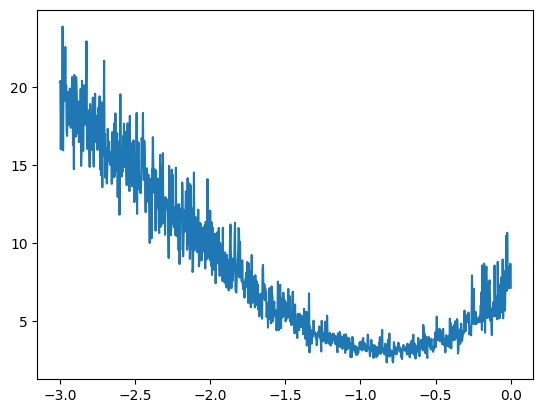

In [116]:
plt.plot(lri, lossi)

So, a learning of .1 is roughly the best learning rate

## Spliting Our Data
We should three different splits of our data:
* Training: Data that is used to train the parameters of the model
* Dev / Validation: Data that is used to train the hyperparameters
* Test: Data that is used evaluate the performance on the model

In [123]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [124]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [125]:
lri = []
lossi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

In [127]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3824, grad_fn=<NllLossBackward0>)

In [128]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3751, grad_fn=<NllLossBackward0>)

Since our training loss and test loss are roughly equal, we're **underfitting** and can make our model better by increasing it's size

## Making Our Model Bigger

In [129]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [140]:
lri = []
lossi = []
stepi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.item())

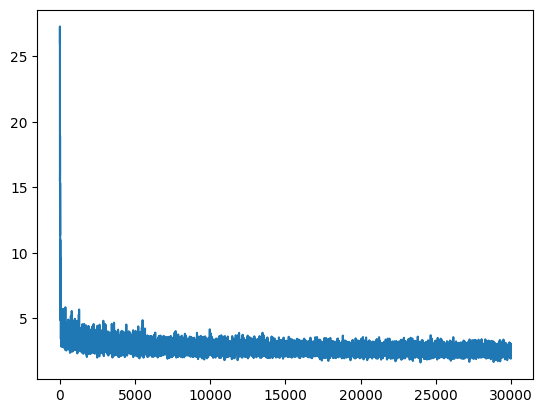

In [131]:
plt.plot(stepi, lossi)

In [141]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2495, grad_fn=<NllLossBackward0>)

In [142]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2447, grad_fn=<NllLossBackward0>)

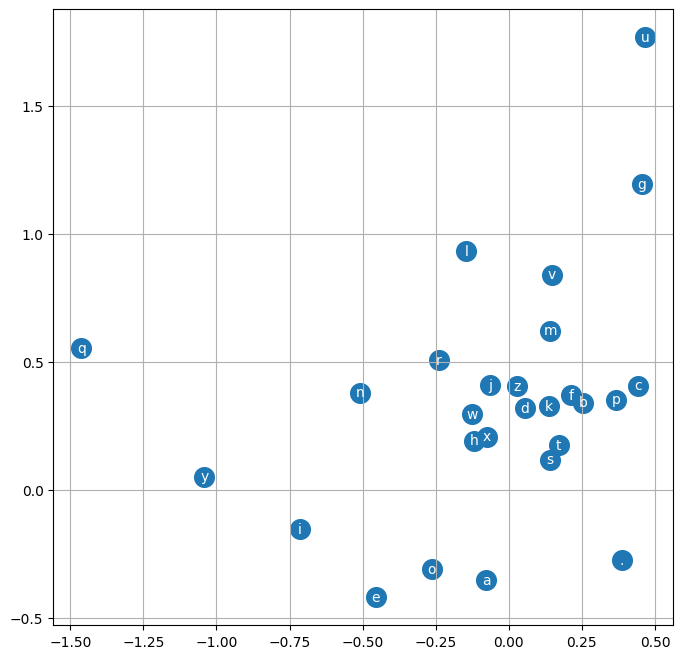

In [143]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1]. data, s = 200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid('minor')

After training our model for maybe 150,000, we get a training loss of 2.29 and a dev loss of 2.24. Our model is still over-fitting, which means maybe our bottle neck wasn't the parameters in our hidden layers.

Let's try increasing the size of our character embeddings.

In [153]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [154]:
lri = []
lossi = []
stepi = []

In [159]:
for i in range(50_000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

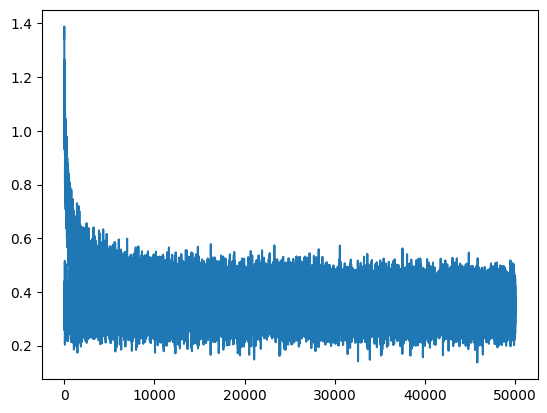

In [160]:
plt.plot(stepi, lossi)

In [161]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1845, grad_fn=<NllLossBackward0>)

In [162]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1799, grad_fn=<NllLossBackward0>)

## Sampling From Model

In [163]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mora.
kmyanniee.
medhayah.
refurdiendrari.
azeerdieli.
jeli.
jenne.
elieananaraelyzioh.
kamin.
shubergiaghiel.
kendrethy.
panthona.
uzabygdariyah.
fael.
yumajaysanyah.
halina.
yarsuf.
zakhlveun.
katri.
kiveaosumptadi.
